In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
today = datetime.today().strftime('%Y%m%d')

In [2]:
training_logs_dir = 'evaluation_logs'
watch_date = '20191118'
logs_df = pd.read_csv('{}.txt'.format(os.path.join(training_logs_dir, watch_date)), sep='\t')
logs_df.head()

,epoch,seed,train,strategy,accuracy,loss
0,1,10,True,freeze,30.204,0.029692
1,1,10,False,freeze,42.210,0.024462
2,2,10,True,freeze,47.316,0.022387
3,2,10,False,freeze,52.900,0.020776
4,3,10,True,freeze,61.366,0.017014


In [3]:
style_args = {
    'linestyle' : {
        'train': '-',
        'test': '--'
    },
    'colors': {
        'freeze': '#B61616',
        'shuffle': '#5AB616',
        'homogeneous': '#26A4C1',
        'heterogeneous': '#3626C1'
    }
}

---

In [4]:
def summarize(df, is_train, strategy, get_acc=True):
    '''
    @df = dataframe with the training/testing logs (epoch, seed, train, shuffle, accuracy, loss)
    @is_train = boolean whether to look at training logs
    @is_shuffle = boolean whether the data is shuffled
    @get_acc = boolean whether to get the accuracy or the loss
    '''
    subset_df = df[['epoch', 'accuracy', 'loss']].loc[(logs_df['train'] == is_train) & (logs_df['strategy'] == strategy)]
    grouped_df = subset_df.groupby('epoch')
    if get_acc:
        return {'mean': grouped_df.mean().values.T[0], 'std': grouped_df.std().values.T[0]}
    else:
        return {'mean': grouped_df.mean().values.T[1], 'std': grouped_df.std().values.T[1]}

In [5]:
def metric_over_epochs(get_acc=True, data_dir='figures'):
    plt.figure(figsize=(12,12))
    best_vals = {}
    for is_train in [True, False]:
        for strategy in ['freeze', 'shuffle', 'homogeneous', 'heterogeneous']:
            # data
            metric_dict = summarize(logs_df, is_train, strategy, get_acc=get_acc)
            
            means = metric_dict['mean']
            stds = metric_dict['std']
            upper_shadow = means + stds
            lower_shadow = means - stds
            idxs = range(len(means))
            
            # graph settings
            train_mode = 'train' if is_train else 'test'
            name = '{}/{}'.format(train_mode, strategy)
            best_vals[name] = max(means)
            color = style_args['colors'][strategy]
            linestyle = style_args['linestyle'][train_mode]

            # plotting
            plt.plot(idxs, means, label=name, color=color, linestyle=linestyle)
            plt.fill_between(idxs, means, upper_shadow, color=color, linestyle=linestyle, alpha=0.5)
            plt.fill_between(idxs, lower_shadow, means, color=color, linestyle=linestyle, alpha=0.5)

    plt.title('Change of {} over epochs'.format('accuracy' if get_acc else 'loss'))
    plt.xlabel('Epochs')
    plt.ylabel('{}'.format('Accuracy' if get_acc else 'Loss'))
    plt.legend();
    plt.plot()
    plt.savefig('{}/{}_{}.jpg'.format(data_dir, today, 'accuracy' if get_acc else 'loss'), format='jpg')
    print("Best values:")
    print(pd.Series(best_vals))

### Notation
- green plots are freezed
- orangish plots are shuffled
- dotted lines show the standard deviation

Best values:
train/freeze           100.000000
train/shuffle          100.000000
train/homogeneous       85.950000
train/heterogeneous    100.000000
test/freeze             86.646667
test/shuffle            89.576667
test/homogeneous        10.000000
test/heterogeneous      89.263333
dtype: float64


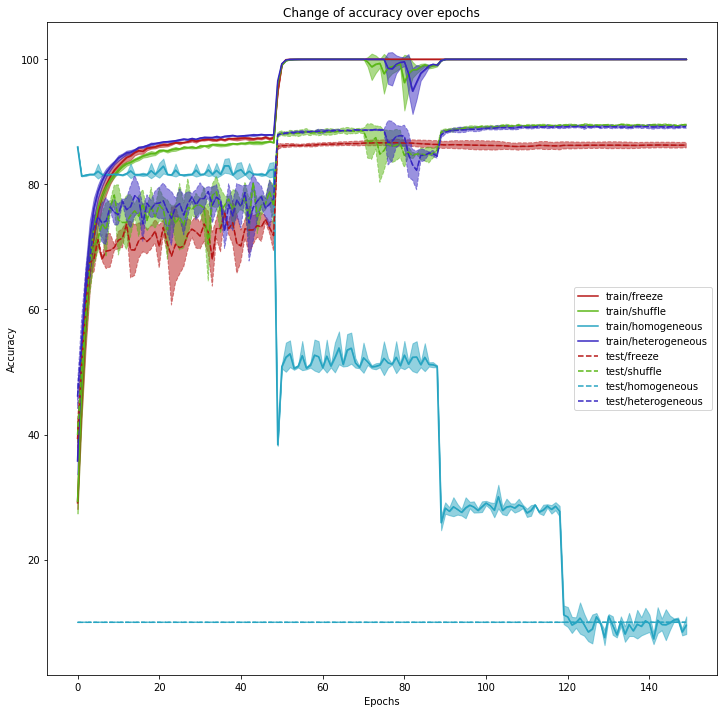

In [6]:
metric_over_epochs(get_acc=True)

Best values:
train/freeze           0.030493
train/shuffle          0.030477
train/homogeneous      0.045918
train/heterogeneous    0.028208
test/freeze            0.025721
test/shuffle           0.025846
test/homogeneous       0.209659
test/heterogeneous     0.023947
dtype: float64


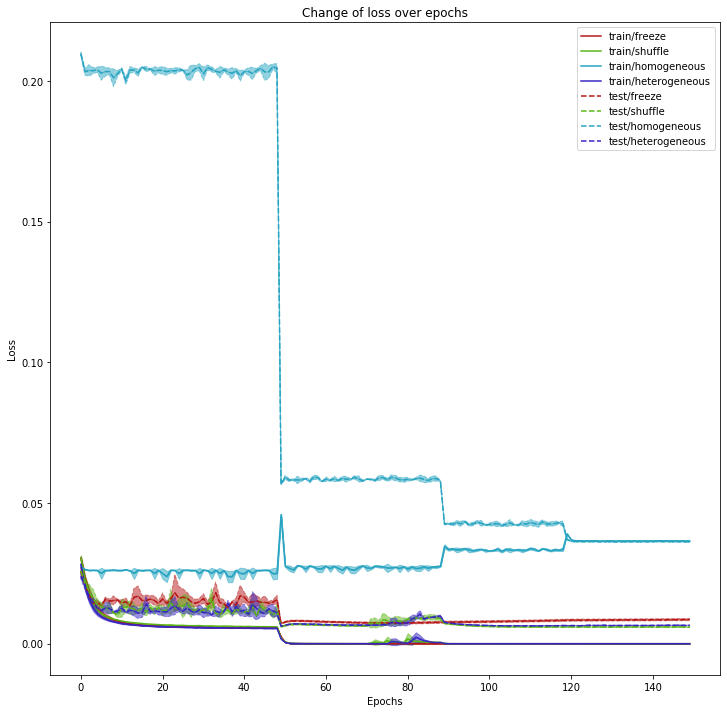

In [7]:
metric_over_epochs(get_acc=False)